# Decision Tree generation

## Import bibliotek i wczytanie danych

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv('titanic-homework.csv')

## Przygotowanie danych 
(versja 4.0)

In [5]:
# usuwamy kolumne 'name'
df = df.drop('Name', axis=1) 

# mapujemy wiek na kategorie
def map_age_to_category(age):
    if age <= 20:
        return 'young'
    elif age <= 40:
        return 'middle'
    else:
        return 'old'

df['Age'] = df['Age'].apply(map_age_to_category) 

print("Dane po przygotowaniu:")
print(df.head(10))
print(f"\nRozmiar zbioru: {len(df)} przykładów")
print(f"\nRozkład klas (Survived):")
print(df['Survived'].value_counts())

Dane po przygotowaniu:
   PassengerId  Pclass     Sex     Age  SibSp  Parch  Survived
0            1       3    male  middle      1      0         0
1            2       1  female  middle      1      0         1
2            3       3  female  middle      0      0         1
3            4       1  female  middle      1      0         1
4            5       3    male  middle      0      0         0
5            6       3    male  middle      0      0         0
6            7       1    male     old      0      0         0
7            8       3    male   young      3      1         0
8            9       3  female  middle      0      2         1
9           10       2  female   young      1      0         1

Rozmiar zbioru: 100 przykładów

Rozkład klas (Survived):
Survived
0    60
1    40
Name: count, dtype: int64


## Entropia

In [6]:
def calculate_entropy(data):
    class_counts = data['Survived'].value_counts()
    total = len(data)
    entropy = 0
    for count in class_counts:
        p = count / total
        if p > 0:
            entropy -= p * np.log2(p)
    return entropy

initial_entropy = calculate_entropy(df)
print(f"Entropia początkowa: {initial_entropy:.4f}")

Entropia początkowa: 0.9710


## Entropia warunkowa

In [7]:
def calculate_conditional_entropy(data, attribute):
    total = len(data)
    conditional_entropy = 0
    
    for value in data[attribute].unique():
        subset = data[data[attribute] == value]
        weight = len(subset) / total
        subset_entropy = calculate_entropy(subset)
        conditional_entropy += weight * subset_entropy
    
    return conditional_entropy

## Information Gain

In [8]:
def calculate_information_gain(data, attribute):
    entropy_before = calculate_entropy(data)
    conditional_entropy = calculate_conditional_entropy(data, attribute)
    return entropy_before - conditional_entropy

## Intrinsic Info i Gain Ratio

In [9]:
def calculate_intrinsic_info(data, attribute):
    total = len(data)
    intrinsic_info = 0
    for value in data[attribute].unique():
        subset = data[data[attribute] == value]
        proportion = len(subset) / total
        if proportion > 0:
            intrinsic_info -= proportion * np.log2(proportion)
    return intrinsic_info

def calculate_gain_ratio(data, attribute):
    information_gain = calculate_information_gain(data, attribute)
    intrinsic_info = calculate_intrinsic_info(data, attribute)    
    if intrinsic_info == 0:
        return 0
    return information_gain / intrinsic_info


attributes = [col for col in df.columns 
              if col not in ['Survived', 'PassengerId']]

## Metryki dla wszystkich atrybutów

In [10]:
print("Obliczanie metryk\n")
results = []
for attr in attributes:
    ig = calculate_information_gain(df, attr)
    ii = calculate_intrinsic_info(df, attr)
    gr = calculate_gain_ratio(df, attr)
    results.append({'Atrybut': attr, 'IG': ig, 'II': ii, 'GR': gr})
    print(f"{attr:12} | IG: {ig:.4f} | II: {ii:.4f} | GR: {gr:.4f}")

metrics_df = pd.DataFrame(results)
best = metrics_df.loc[metrics_df['GR'].idxmax()]
print(f"\nNajlepszy: {best['Atrybut']} (GR={best['GR']:.4f})")

Obliczanie metryk

Pclass       | IG: 0.0817 | II: 1.3702 | GR: 0.0596
Sex          | IG: 0.3915 | II: 0.9710 | GR: 0.4032
Age          | IG: 0.0093 | II: 1.4907 | GR: 0.0063
SibSp        | IG: 0.0407 | II: 1.6191 | GR: 0.0251
Parch        | IG: 0.0166 | II: 1.1326 | GR: 0.0146

Najlepszy: Sex (GR=0.4032)


## Budowanie drzewa

In [11]:
class DecisionTreeNode:
    def __init__(self, attribute=None, label=None, branches=None, class_distribution=None):
        self.attribute = attribute
        self.label = label
        self.branches = branches if branches else {}
        self.class_distribution = class_distribution

def select_best_attribute(data, attributes):
    best_attribute = None
    best_gain_ratio = -1
    for attribute in attributes:
        ig = calculate_information_gain(data, attribute)
        ii = calculate_intrinsic_info(data, attribute)
        gr = ig / ii if ii > 0 else 0
        if gr > best_gain_ratio:
            best_gain_ratio = gr
            best_attribute = attribute
    return best_attribute

def build_decision_tree(data, attributes, depth=0, max_depth=10):
    class_counts = data['Survived'].value_counts().to_dict()
    total = len(data)
    print(f"{'  ' * depth}Poziom {depth}: {total} przykładów, {class_counts}")
    
    # warunek 1: czysty węzeł
    if len(class_counts) == 1:
        label = data['Survived'].iloc[0]
        print(f"{'  ' * depth}  → LIŚĆ: klasa {label}")
        return DecisionTreeNode(label=label, class_distribution=class_counts)
    
    # warunek 2: brak atrybutów
    if len(attributes) == 0 or depth >= max_depth:
        label = data['Survived'].mode()[0]
        print(f"{'  ' * depth}  → LIŚĆ: większościowa {label}")
        return DecisionTreeNode(label=label, class_distribution=class_counts)
    
    # wybieramy najlepszy atrybut
    best_attr = select_best_attribute(data, attributes)
    print(f"{'  ' * depth}  Podział wg: {best_attr}")
    
    # tworzymy węzeł
    node = DecisionTreeNode(attribute=best_attr, class_distribution=class_counts)
    
    # rekurencja
    remaining_attributes = [a for a in attributes if a != best_attr]
    for value in sorted(data[best_attr].unique()):
        subset = data[data[best_attr] == value]
        print(f"{'  ' * depth}    Gałąź: {best_attr} = {value}")
        node.branches[value] = build_decision_tree(subset, remaining_attributes, depth + 1, max_depth)
    return node

In [14]:
print("Budowanie drzewa")
attributes = [col for col in df.columns 
              if col not in ['Survived', 'PassengerId']]
tree = build_decision_tree(df, attributes, max_depth=5)
print("Drzewo zbudowane")

Budowanie drzewa
Poziom 0: 100 przykładów, {0: 60, 1: 40}
  Podział wg: Sex
    Gałąź: Sex = female
  Poziom 1: 40 przykładów, {1: 33, 0: 7}
    Podział wg: SibSp
      Gałąź: SibSp = 0
    Poziom 2: 19 przykładów, {1: 19}
      → LIŚĆ: klasa 1
      Gałąź: SibSp = 1
    Poziom 2: 15 przykładów, {1: 11, 0: 4}
      Podział wg: Pclass
        Gałąź: Pclass = 1
      Poziom 3: 4 przykładów, {1: 4}
        → LIŚĆ: klasa 1
        Gałąź: Pclass = 2
      Poziom 3: 5 przykładów, {1: 5}
        → LIŚĆ: klasa 1
        Gałąź: Pclass = 3
      Poziom 3: 6 przykładów, {0: 4, 1: 2}
        Podział wg: Parch
          Gałąź: Parch = 0
        Poziom 4: 4 przykładów, {0: 4}
          → LIŚĆ: klasa 0
          Gałąź: Parch = 1
        Poziom 4: 1 przykładów, {1: 1}
          → LIŚĆ: klasa 1
          Gałąź: Parch = 5
        Poziom 4: 1 przykładów, {1: 1}
          → LIŚĆ: klasa 1
      Gałąź: SibSp = 2
    Poziom 2: 1 przykładów, {0: 1}
      → LIŚĆ: klasa 0
      Gałąź: SibSp = 3
    Poziom 2: 3 

## Wizualizacja

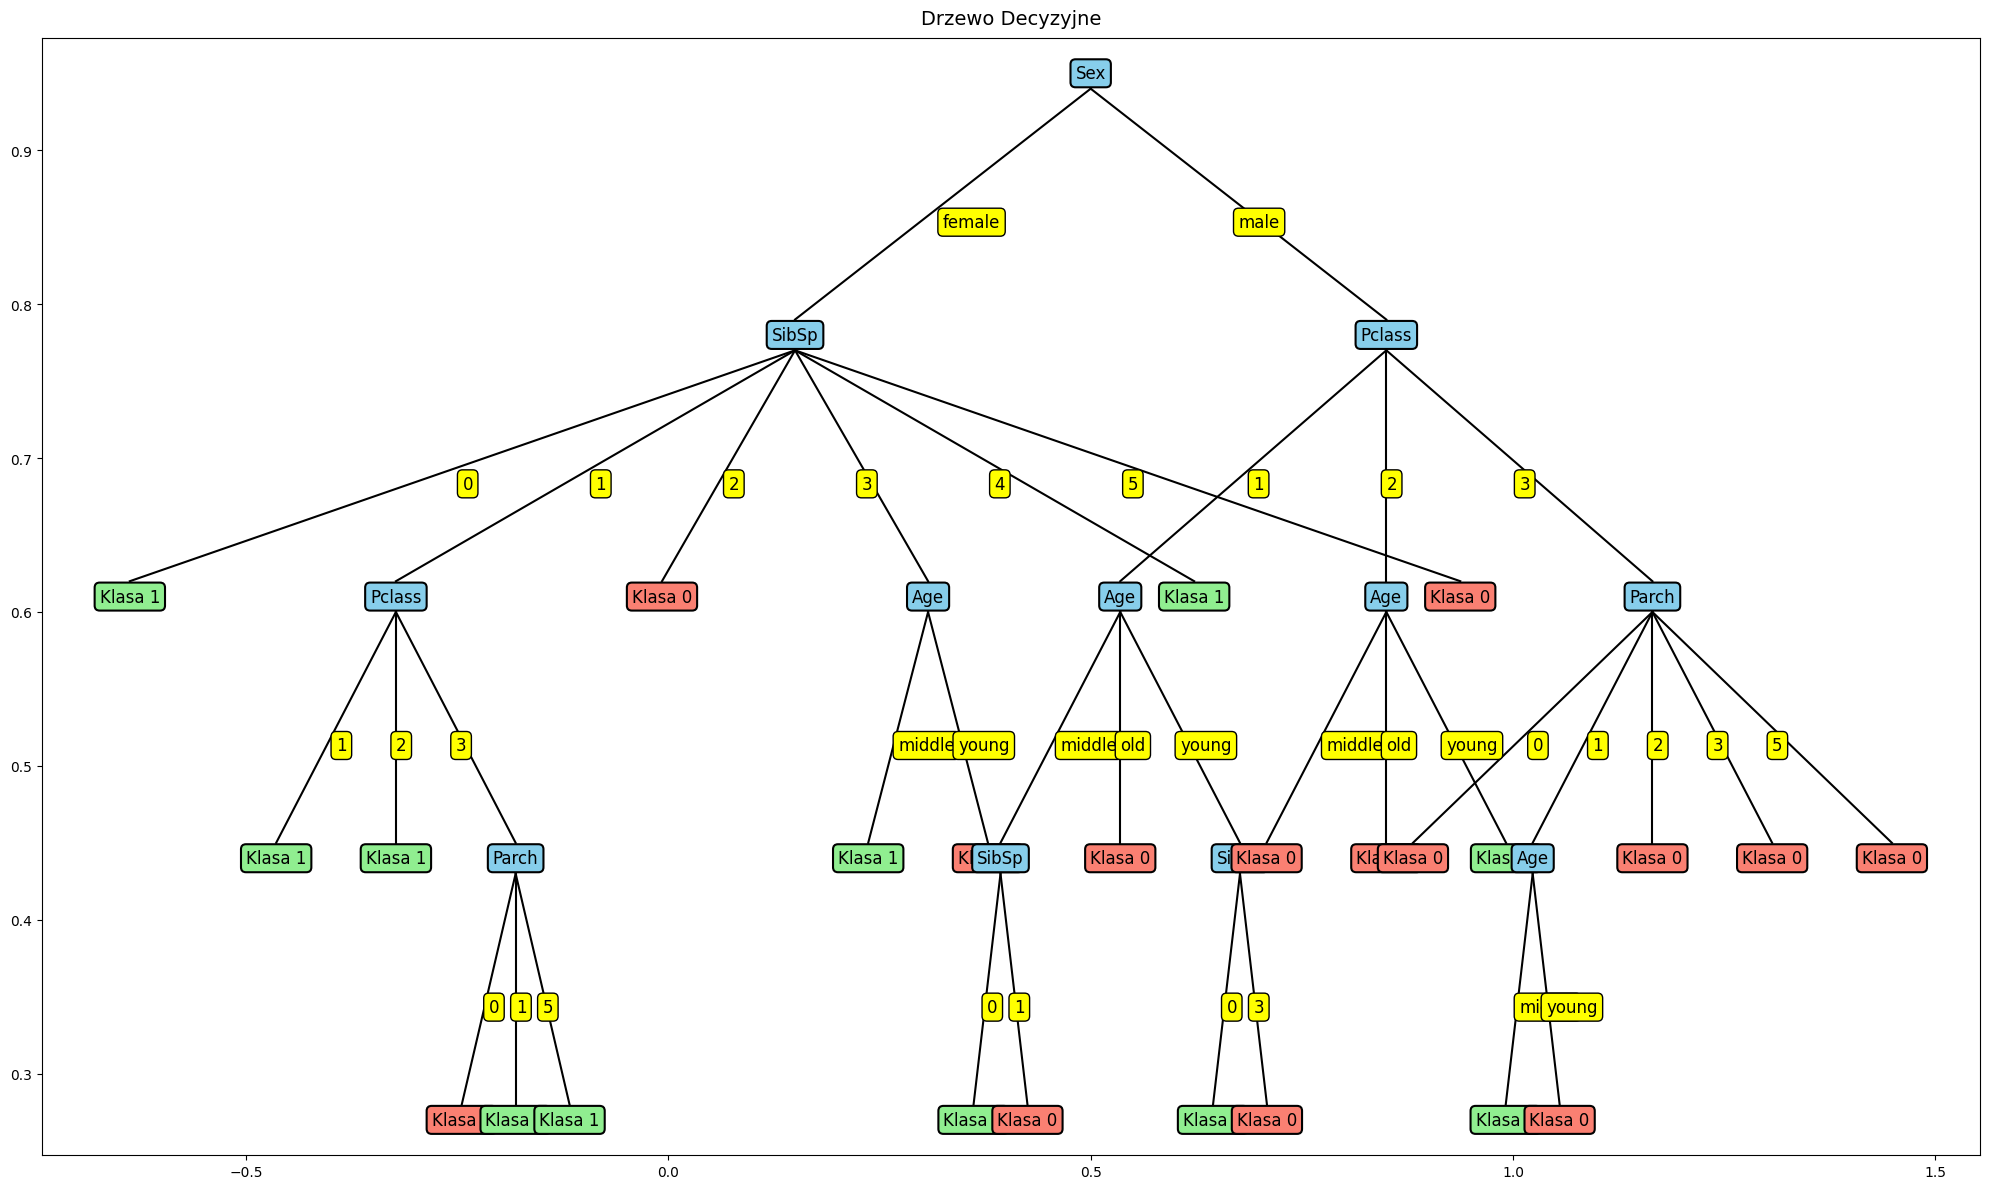

In [15]:
## Wizualizacja
import matplotlib.pyplot as plt

def draw_tree(node, x=0.5, y=0.95, dx=0.7, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')

    # Węzeł
    label = f"Klasa {node.label}" if node.label is not None else node.attribute
    color = 'lightgreen' if node.label == 1 else 'salmon' if node.label == 0 else 'skyblue'
    ax.text(x, y, label, ha='center', va='center', fontsize=12,
            bbox=dict(boxstyle='round', fc=color, ec='black', lw=1.5))

    # Gałęzie
    if node.branches:
        for i, (val, child) in enumerate(sorted(node.branches.items())):
            cx = x + (i - len(node.branches) / 2 + 0.5) * dx
            ax.plot([x, cx], [y - 0.01, y - 0.16], 'k-', lw=1.5)
            ax.text((x + cx) / 2, y - 0.10, str(val), fontsize=12,
                    bbox=dict(boxstyle='round', fc='yellow'))
            draw_tree(child, cx, y - 0.17, dx * 0.45, ax)


fig, ax = plt.subplots(figsize=(20, 12))
draw_tree(tree, ax=ax)
plt.title('Drzewo Decyzyjne', fontsize=14, pad=10)
plt.tight_layout()
plt.show()